In [1]:
from dotenv import load_dotenv
load_dotenv("../.env", override=True)

True

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)

In [3]:
llm.invoke("What is the capital of France?").content

'The capital of France is Paris.'

In [4]:
from pydantic import BaseModel, Field

class SearchQuery(BaseModel):
    search_query: str = Field(
        None, description="Query that is optimized to search the web."
    )
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )

structured_llm = llm.with_structured_output(SearchQuery)
output = structured_llm.invoke(
    "How does Calcium CT score relate to high cholesterol?"
)
output.search_query, output.justification

('Calcium CT score high cholesterol relationship',
 'The user is asking about the relationship between Calcium CT score and high cholesterol, which requires a web search to provide an accurate answer about medical correlations and risk factors. ')

In [5]:
def multiply(a: int, b: int) -> int:
    """Multiplies two numbers."""
    return a * b

llm_with_tools = llm.bind_tools([multiply])

msg = llm_with_tools.invoke("What is 2 times 3?")

msg.tool_calls[0]["name"], msg.tool_calls[0]["args"]

('multiply', {'a': 2.0, 'b': 3.0})

In [6]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

def generate_joke(state: State):
    """First LLM call to generate initial joke"""
    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

def check_pounchline(state: State):
    """Gate function to check if the joke has a punchline"""
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"

def improve_joke(state: State):
    """Second LLM call to improve the joke"""
    msg = llm.invoke(
        f"Make this joke funnier by adding wordplay: {state['joke']}"
    )
    return {"improved_joke": msg.content}

def polish_joke(state: State):
    """Third LLM call to final Polish the joke"""
    msg = llm.invoke(
        f"Add a surprising twist to this joke: {state['improved_joke']}"
    )
    return {"final_joke": msg.content}

In [8]:
workflow = StateGraph(State)

workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", 
    check_pounchline,
    {"Fail": "improve_joke", "Pass": END} 
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

chain = workflow.compile()


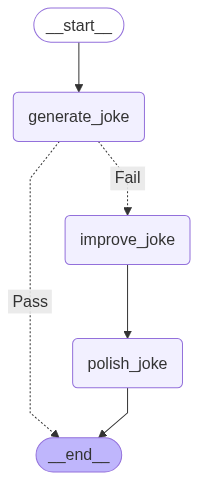

In [9]:
display(Image(chain.get_graph().draw_mermaid_png()))

In [14]:
state = chain.invoke({"topic": "cats"})

In [15]:
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

Initial joke:
Why did the cat sit on the computer?

Because it wanted to keep an eye on the mouse!

--- --- ---

Joke failed quality gate - no punchline detected!


In [16]:
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str

In [17]:
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""
    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

In [18]:
def call_llm_2(state: State):
    """Second LLM call to generate a short story"""
    msg = llm.invoke(f"Write a short story about {state['topic']}")
    return {"story": msg.content}

In [19]:
def call_llm_3(state: State):
    """Third LLM call to generate a short poem"""
    msg = llm.invoke(f"Write a short poem about {state['topic']}")
    return {"poem": msg.content}

In [20]:
def aggregator(state: State):
    """Combine the joke and story into a single output"""
    combined_output = (
        f"Here's a story, joke and poem about {state['topic']}:\n"
        f"Joke: {state['joke']}\n"
        f"Story: {state['story']}\n"
        f"Poem: {state['poem']}"
    )
    return {"combined_output": combined_output}

In [22]:
parallel_builder = StateGraph(State)

parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)

parallel_workflow = parallel_builder.compile()

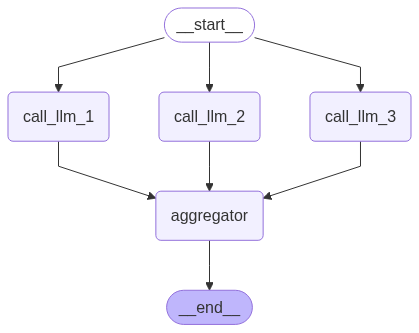

In [23]:
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

In [25]:
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

Here's a story, joke and poem about cats:
Joke: Why did the cat sit on the computer?

Because it wanted to keep an eye on the mouse!
Story: Jasper, a magnificent marmalade ginger, was a creature of profound contentment. His current state involved a perfect rectangle of sunlight on the living room rug, into which he had melted like a furry, warm puddle. A slow, rhythmic purr vibrated through his substantial chest, a testament to the warmth soaking into his fur and the utter lack of immediate threats. His tail, a fluffy question mark, twitched occasionally, perhaps dreaming of chasing dust motes.

Then came Luna.

A sleek, midnight-black blur, Luna was the antithesis of Jasper’s languid grace. She didn't walk; she *prowled*, a low-slung hunter with twitching whiskers and boundless energy. Her eyes, emerald chips, scanned the room for any sign of mischief, any opportunity for a chase.

Today, the opportunity presented itself in the form of a particularly brave (or foolish) fly buzzing nea

In [ ]:
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage

class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process."
    )

router = llm.with_structured_output(Route)


In [29]:
class State(TypedDict):
    input: str
    decision: str
    output: str

def llm_call_1(state: State):
    """Write a story"""
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_2(state: State):
    """Write a joke"""
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_3(state: State):
    """Write a poem"""
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_router(state: State):
    """Route the input to the appropriate node"""
    
    # Run the augmented LLM with structured output to serve as 
    # routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the input's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )
    return {"decision": decision.step}

In [30]:
def route_decision(state: State):
    """Route the decision to the appropriate node"""
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"
    else:
        raise ValueError(f"Unknown decision: {state['decision']}")

In [32]:
router_builder = StateGraph(State)

router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)

router_builder.add_node("llm_call_router", llm_call_router)

router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    }
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

router_workflow = router_builder.compile()


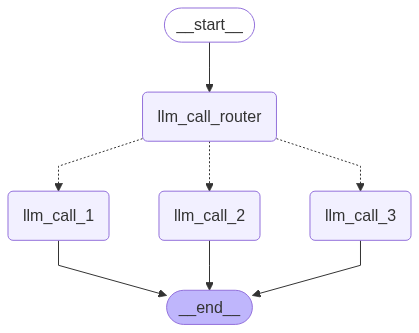

In [33]:
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [35]:
state = router_workflow.invoke({"input": "Write joke about cats."})
print(state["output"])

Why did the cat get kicked out of the library?

Because it kept purr-loining all the books!


## Orchestrator Worker

In [39]:
from typing import Annotated, List

# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        None, description="Name for this section of te report ."
    )
    descriptor: str = Field(
        None, description="Brief overview of the main topics and concepts to be covered in this section.."
    )

class Sections(BaseModel):
    sections: List[Section] = Field(
        None, description="Sections of the report."
    )

# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

## Creating Workers in LangGraph

Because orchestrator-worker workflows are common, LangGraph has the Send API to support this. It lets you dynamically create worker nodes and send each one a specific input. Each worker has its own state, and all worker outputs are written to a shared state key that is accessible to the orchestrator graph. This gives the orchestrator access to all worker output and allows it to synthesize them into a final output. As you can see below, we iterate over a list of sections and Send each to a worker node.

In [47]:
import operator

# Graph state
class State(TypedDict):
    topic: str # Report topic
    sections: list[Section] # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ] # All workers write to this key in parallel
    final_report: str # Final report output

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

def orchestrator(state: State):
    """Orchestrator that generates a plan for the report."""
    # Generate Queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}.")
        ]
    )

    return {"sections": report_sections.sections}

In [44]:
def llm_call(state: WorkerState):
    """Worker writes a section of the report."""
    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].descriptor}."
            )
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}

In [45]:
def syntesizer(state: State):
    """Synthesize full report from sections."""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Fortmat completed sections to str and use and use as context for the final sections
    completed_report_sections = "\n\n--\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}
    

In [52]:
from langgraph.types import Send

# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""
    return [
        Send(
            "llm_call",
            {"section": section},
        )
        for section in state["sections"]
    ]

In [54]:
# Build the workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("syntesizer", syntesizer)

# Add the edges
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator",
    assign_workers,
    ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "syntesizer")
orchestrator_worker_builder.add_edge("syntesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()


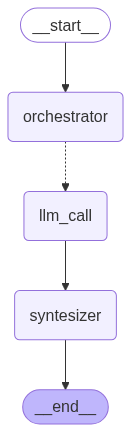

In [55]:
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [56]:
# invoke

state = orchestrator_worker.invoke({"topic": "Create a report on LLM Scaling Laws"})

In [57]:
from IPython.display import Markdown
Markdown(state["final_report"])

## Introduction

Large Language Models (LLMs) have demonstrated remarkable capabilities, a phenomenon significantly illuminated and guided by the discovery of "Scaling Laws." These laws describe predictable relationships between model performance and key resources such as compute, data, and model size (number of parameters). Far from being mere empirical observations, scaling laws provide a foundational understanding of how LLMs learn and generalize, revealing that performance improvements are not solely dependent on architectural innovations but also, and often more profoundly, on the sheer scale of resources invested.

The significance of LLM scaling laws cannot be overstated. They offer a roadmap for the efficient allocation of computational resources, enabling researchers and engineers to predict the performance gains achievable by increasing model size, training data, or training time. This predictability has been instrumental in the rapid advancement of the field, guiding the development of increasingly powerful models like GPT-3, PaLM, and LLaMA. Furthermore, they suggest that current LLM capabilities are not nearing fundamental limits but rather are a function of the scale at which they are trained, implying a clear path for future improvements through continued scaling.

Foundational concepts underpinning these laws include the idea of "power-law relationships," where one quantity varies as a power of another, leading to linear relationships on a log-log plot. Key resources considered are the number of model parameters ($N$), the size of the training dataset ($D$), and the total compute budget ($C$, often measured in FLOPs). Scaling laws typically express the test loss (or perplexity) as a function of these variables, demonstrating that as $N$, $D$, or $C$ increase, the loss decreases predictably, often following distinct power-law exponents for each resource. This framework allows for the optimization of training strategies, balancing these resources to achieve the best possible performance for a given budget.